# 1. Repo Preparation

Install package 
- obs_lsst: git clone https://github.com/lsst/obs_lsst.git

Checkout proper commit:

```
cd obs_lsst
git checkout -b fake_test 30368a2b8c2941f1a04c704048c33e056a6af57b
cd ..
```
- dia_pipe: git clone https://github.com/LSSTDESC/dia_pipe.git

Checkout proper commit:

```
cd dia_pipe
git checkout -b fake_test 8ae16a9f5e5c1e4f174626b7f1e002b9d0c69b8f
cd ..
```

```
commit 8ae16a9f5e5c1e4f174626b7f1e002b9d0c69b8f (HEAD, origin/#19)
Author: Bob Armstrong <rearmstr@gmail.com>
Date:   Tue Feb 2 14:16:07 2021 -0800
```

- pipe_task: git clone https://github.com/lsst/pipe_tasks.git

Checkout proper commit:
```
cd pipe_tasks
git checkout -b fake_test 7c1b45f03a170bb471028729aad273843dfa3b28
cd ..
```

```
HEAD -> u/wmwv/dia_apcorr, origin/u/wmwv/dia_apcorr, Actually create the applyApCorr subtask.
```



Create setup.sh
```
#！/bin/bash

source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/v20.0.0/loadLSST.bash
setup lsst_distrib

# scons only need to be done only once. 
# setup -jr dia_pipe and setup -jr pipe_tasks need to be kept.

cd dia_pipe
scons
cd ..
setup -jr dia_pipe

cd pipe_tasks
scons
cd ..
setup -jr pipe_tasks

export HDF5_USE_FILE_LOCKING=FALSE
export OMP_NUM_THREADS=1

echo 'done'
```
In terminal, run `source setup.sh`

# 2. Inject Fakes and Run subtraction

In [29]:
import fakeInjectionPipeline as fip


patch_list = ['00']
host_mag_list = ['20_21']
fake_mag_list = [20]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

# calexp_info_dict contains dataframes of visit infomation of each host magnitude bin
# injection_coord_dict contains positions for injection
calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)

# we test only one detector
calexp_info, injection_coord = {}, {}
calexp_info['00_20_21'] = calexp_info_dict['00_20_21'].iloc[0:1]
injection_coord['00_20_21_1013665_79_i'] = injection_coord_dict['00_20_21_1013665_79_i'][0:4]

In [30]:
# initialize an injector object to perform fake injection
fake_dir = f'./data/patch_0to6/injection'
injector = fip.fakeInjectionPipeline(
    fake_dir = fake_dir, patch_list = patch_list,
    host_mag_list=host_mag_list, fake_mag_list=fake_mag_list,
    calexp_info_dict=calexp_info, injection_coord_dict=injection_coord
)

# create directories for injection
injector.make_fake_repo()

In [31]:
# inject fakes
injector.inject_fakes(poisson=False)

patch:  00
host mag:  20_21


injection is done


In [35]:
# config type
cf_type = 'default'

config = f'./config/diffimConfig_al_{cf_type}.py'
# path of the subtraction script
file_path = f'./al_{cf_type}.sh'
# directory of the difference image
diff_dir =  f'./data/patch_0to6/diff/al_{cf_type}'
# get subtraction script and run it in the terminal opened before
injector.get_subtraction_script(diff_dir , config=config, file_path=file_path, use_slurm=False)

please run this file: ./al_default.sh


# 3. Get Detection Database and Perform Forced Photometry

After running subtraction scripts, rub the next cell to get detection

In [36]:
# directory of detection database
flux_dir = f'./data/patch_0to6/diff/al_{cf_type}/detection'
injector.get_detection(diff_dir=diff_dir, flux_dir=flux_dir, db_name=f'detection.sqlite')

patch 00, visit 1013665, filter i, detector 79, fake mag 20


detection results are saved in ./data/patch_0to6/diff/al_default/detection/detection.sqlite
fake_src contains the fake information, and artifact contains the artifact information


In [37]:
# extract detected positions for forced photometry
flux_db_path = f'./data/patch_0to6/diff/al_{cf_type}/detection/detection.sqlite'
coord_dir = f'./data/patch_0to6/diff/al_{cf_type}/coord'
injector.get_detection_coord(flux_db_path, coord_dir)

forced photometry coordinates are saved in ./data/patch_0to6/diff/al_default/coord


In [38]:
# directory of forced photometry results
forced_dir = f'./data/patch_0to6/diff/al_{cf_type}/forced'
forced_config = './config/forcedConfig.py'
# path of the forced photometry script
forced_path = f'./forced_al_{cf_type}.sh'
injector.get_forced_phot_script(diff_dir, coord_dir, forced_dir, forced_config, file_path=forced_path)

patch:  00
host mag:  20_21


please run this file: ./forced_al_default.sh


In [39]:
# after performing forced photometry, we save the results to a database called forced sqlite
injector.get_forced_db(coord_dir, forced_dir, db_name='forced.sqlite')

# 4. Visualizaiton

In [53]:
import seaborn as sns 
import sqlite3
import numpy as np
import pandas as pd

In [42]:
conn = sqlite3.connect('./data/patch_0to6/diff/al_default/detection/detection.sqlite')
query = 'SELECT * FROM fake_src'
fake_src_df = pd.read_sql_query(query, conn)

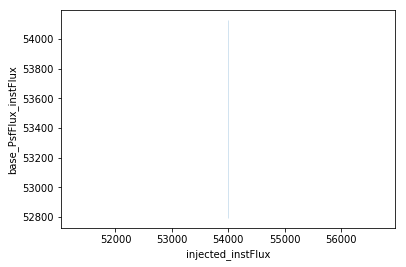

In [71]:
sns.lineplot(data=fake_src_df, x='injected_instFlux', y='base_PsfFlux_instFlux')

In [72]:
forced_db = ('./data/patch_0to6/diff/al_default/forced/forced.sqlite')
conn = sqlite3.connect(forced_db)
forced_flux = pd.read_sql_query('SELECT * FROM forced', conn)

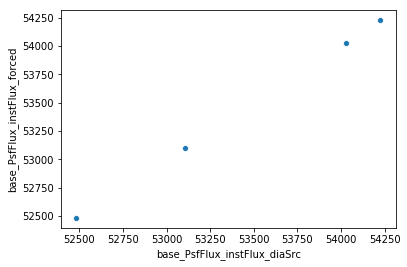

In [73]:
sns.scatterplot(x=forced_flux['base_PsfFlux_instFlux_diaSrc'], y=forced_flux['base_PsfFlux_instFlux_forced'])